In [ ]:
# Prophet is a Python time series forecast library developed by Facebook.
# Prophet automatically detects yearly, weekly, and daily seasonality.
# It can quickly decompose the trend and seasonality effects.

# Step 1: Install And Import Libraries

In [ ]:
# In the first step, we will install and import libraries.
# Two Python packages need to be installed, `yfinance` and `prophet`.

In [ ]:
# Install libraries
!pip install yfinance prophet

After the package installation, we need to import libraries for this tutorial.

`numpy` and `pandas` are for data processing. `yfinance` is for pulling the data.

Prophet is for building the time series forecast. `.plot` is for model output visualization, and `.diagnostics` is for model performance evaluation.

`plotly` is imported to visualize the Bitcoint price trend.


In [ ]:
# Data processing
import numpy as np
import pandas as pd

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import plotly.graph_objs as go

# Step 2: Get Bitcoin Price Data

In the 2nd step, the Bitcoin price data is downloaded from the Yahoo finance API. We are using two years' daily data from 2018 and 2019.

Yahoo finance downloads data with the date as an index. Using `reset_index`, we created a new index and used the date as a column. This is because Prophet requires the date-time variable to be a column for the model input.

By default, the date is string type, `pd.to_datetime` changes it to a DateTime format.

In [ ]:
# Download Bitcoin data
data = yf.download(tickers='BTC-USD', start='2020-01-01', end='2023-11-06', interval = '1d')

# Reset index and have date as a column
data.reset_index(inplace=True)

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
1,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
3,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
4,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


From the trend chart, we can see that the Bitcoin price started to decrease in January 2018 and increased since April 2019.

In [ ]:
# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

In this tutorial, we will forecast the Bitcoin close price. Prophet takes two columns as inputs, a datetime column called `ds` and a value column called `y`. Therefore, we need to drop all the other columns, rename `Date` to `ds` and `Close` to `y`.

In [ ]:
# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename (columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Take a look at the data
df.head ()

,ds,y
0,2020-01-01,7200.174316
1,2020-01-02,6985.470215
2,2020-01-03,7344.884277
3,2020-01-04,7410.656738
4,2020-01-05,7411.317383


In [ ]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1405 non-null   datetime64[ns]
 1   y       1405 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.1 KB


# Step 3: Train Test Split

In step 3, a training and a testing dataset are created. We cannot use random split for time series data because it causes data leakage from the future dates to the past dates. Usually, a cutoff date is selected. The data before the cutoff date is the training dataset, and the data after the cutoff date is used as the testing dataset.

In [ ]:
# Train test split
df_train = df[df['ds']<='2023-09-30']
df_test = df[df['ds']>'2023-09-30']

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 1369 records, ranging from 2020-01-01 00:00:00 to 2023-09-30 00:00:00
The testing dataset has 36 records, ranging from 2023-10-01 00:00:00 to 2023-11-05 00:00:00


# Step 4: Train Time Series Model Using Prophet

In step 4, we will train the time series model using the training dataset.

In [ ]:
# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.95, n_changepoints=7)

# Fit the model using the training dataset
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyrt1rzm4/2l4am4nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyrt1rzm4/4qly9ws1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71340', 'data', 'file=/tmp/tmpyrt1rzm4/2l4am4nn.json', 'init=/tmp/tmpyrt1rzm4/4qly9ws1.json', 'output', 'file=/tmp/tmpyrt1rzm4/prophet_model9oh2jeu2/prophet_model-20231109181337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# The yearly seasonality and daily seasonality are automatically disabled.
# This is because Prophet detects that the dataset we are using does
# not have full multiple years of data and does not have units smaller than a day.

## Step 5: Use Prophet Model To Make Prediction

In [ ]:
# Step 5 uses the trained Prophet model to make the prediction.
# This is the same as using the testing dataset we created above.
# The prediction output contains lots of information. We kept the predicted value `yhat`
# and its prediction interval upper and lower bound value.

In [ ]:
# Create a future dataframe for prediction
future = m.make_future_dataframe(periods=31)

# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1395,2023-10-27,43049.914463,33537.887931,52614.431781
1396,2023-10-28,43221.581413,33668.612701,52648.899910
1397,2023-10-29,43389.428472,33871.503114,51799.073575
1398,2023-10-30,43502.986768,34346.227888,52560.709601
1399,2023-10-31,43620.977000,34849.123756,52975.917451


The x-axis is the date in the forecast visualization, and the y axis is the Bitcoin close price. The black dots are the actual prices in the training dataset, and the red dots are the actual forecast prices. The blue line is the time series model prediction. The shaded area is the 95% prediction interval.

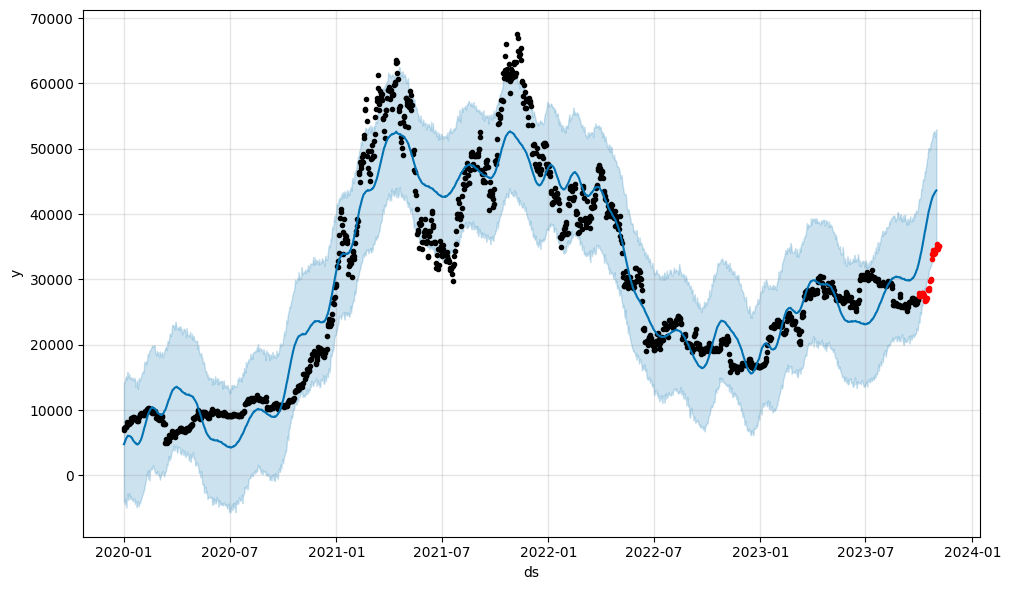

In [ ]:
# Visualize the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

# Step 6: Time Series Decomposition

In step 6, we will decompose the time series forecast.

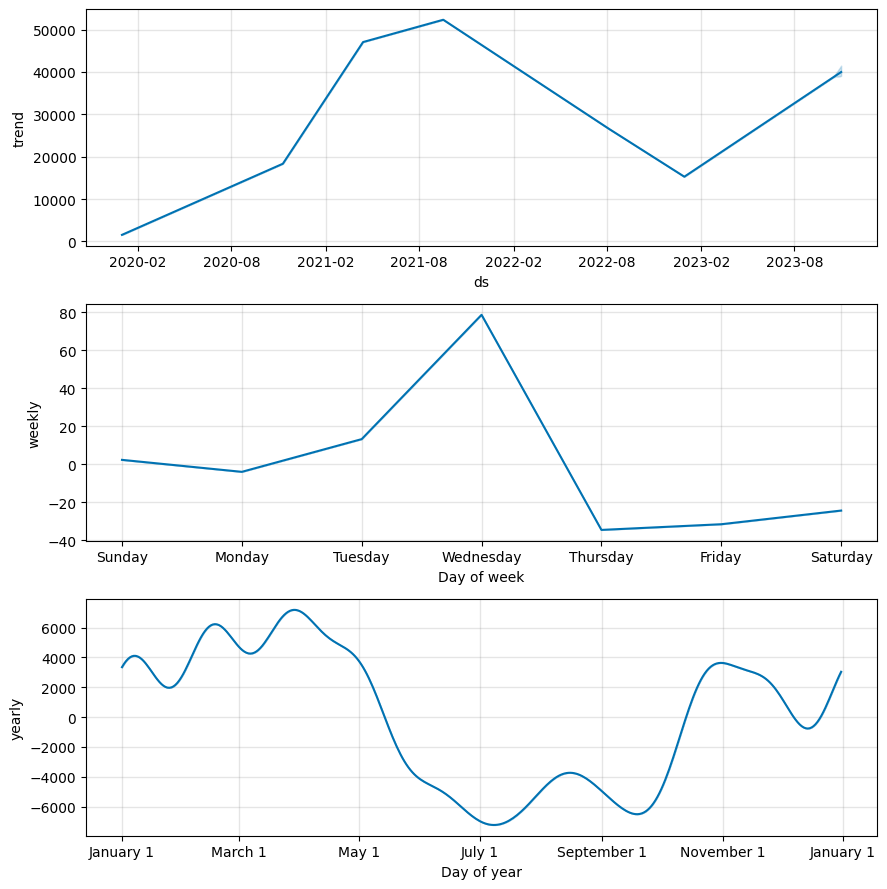

In [ ]:
# Visualize the components
m.plot_components(forecast);

# Step 7: Identify Change Points

Prophet automatically identifies the change points in time series data following the steps below:
1. Specify the percentage of data used for identifying change points. The default is 80%.
2. Identify a large number of uniformly distributed dates with possible trajectories change.
3. Apply a sparse prior on the magnitudes of the change rate, which is similar to L1 regularization.

We can list the dates corresponding to the changepoints using `.changepoints`.

In [ ]:
# Default change points
print(f'There are {len(m.changepoints)} change points. \nThe change points dates are \n{df.loc[df["ds"].isin(m.changepoints)]}')

There are 7 change points. 
The change points dates are 
             ds             y
156  2020-06-05   9665.533203
313  2020-11-09  15332.315430
469  2021-04-14  63109.695312
625  2021-09-17  47267.519531
781  2022-02-20  38431.378906
938  2022-07-27  22930.548828
1094 2022-12-30  16602.585938


In the visualization, the red dotted lines represent the changepoints. It does not include all the seven changepoints in the chart. Only the ones with more changes are included.

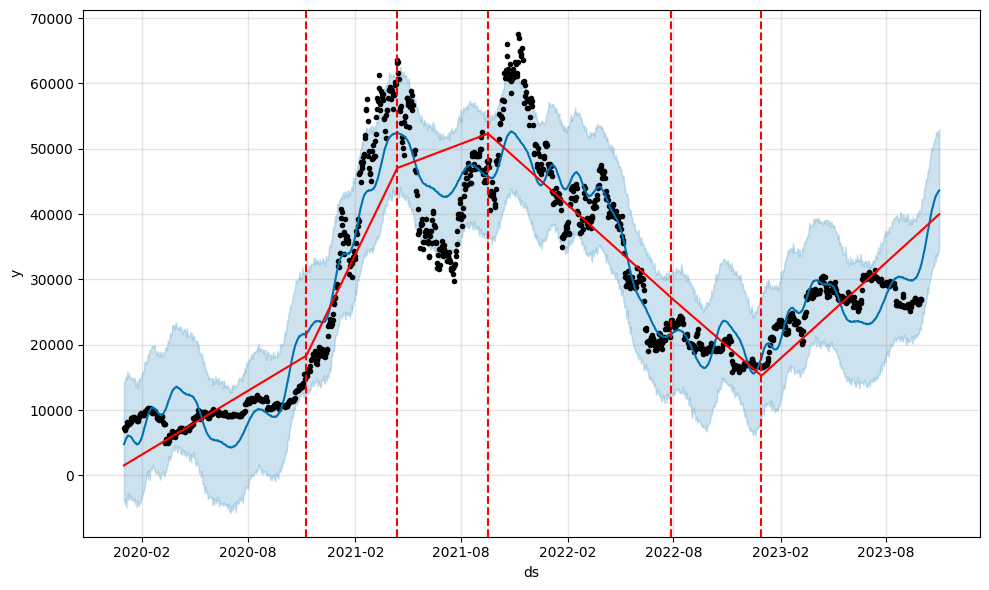

In [ ]:
# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Step 8: Cross Validation

In step 8, we will do cross-validation for the time series model. Prophet has a `cross_validation` function to automate the comparison between the actual and the predicted values.
* `m' is the trained model.
* `initial='500 days" means the initial model will be trained on the first 500 days of data.
* `period='60 days" means 60 days will be added to the training dataset for each additional model.
* `horizon = '30 days'` means that the model forecasts the next 30 days. When only `horizon` is given, Prophet defaults `initial` to be triple the `horizon`, and `period` to be half of the `horizon`.
* `parallel="processes"` enables parallel processing for cross-validation. When the parallel cross-validation can be done on a single machine, "processes" provide the highest performance. For larger problems, "dask" can be used to do cross-validation on multiple machines.




In [ ]:
# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 14 forecasts with cutoffs between 2021-07-12 00:00:00 and 2023-08-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e55baf34910>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyrt1rzm4/_b5h3a8g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyrt1rzm4/n3cwglb7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyrt1rzm4/fz2nk1id.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyrt1rzm4/f6991ifl.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13946', 'data', 'file=/tmp/tmpyrt1rzm4/_b5h3a8g.json', 'init=/tmp/tmpyrt1rzm4/fz2nk1id.json', 'output', 'file=/tmp/tmpyrt1rzm4/prophet_modelf2ani732/prophet_model-20231109181340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
18:13:40 - cmdstanpy - INFO 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-07-13,28970.723732,24296.056234,33553.572052,32702.025391,2021-07-12
1,2021-07-14,28637.359656,24123.894000,33818.589809,32822.347656,2021-07-12
2,2021-07-15,28253.779820,23616.167006,33099.066324,31780.730469,2021-07-12
3,2021-07-16,27881.454292,23294.830208,32528.206276,31421.539062,2021-07-12
4,2021-07-17,27507.684015,22797.642695,32374.891302,31533.068359,2021-07-12


## Step 9: Prophet Model Performance Evaluation

Step 9 evaluates the cross-validation model performance.
* MSE (Mean Squared Error) sums up the squared difference between actual and prediction and is divided by the number of predictions.
* RMSE (Root Mean Square Error) takes the square root of MSE.
* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it's undefined when the actual value is zero.
* MDAPE (Median Absolute Percentage Error) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
* SMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

In [ ]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,4.279444e+07,6541.746319,3854.192620,0.119112,0.075538,0.111936,0.928571
1,4 days,4.311961e+07,6566.552741,3977.553444,0.124537,0.084168,0.118147,0.928571
2,5 days,4.570097e+07,6760.249244,4247.710260,0.136807,0.089535,0.130239,0.904762
3,6 days,4.951701e+07,7036.832350,4721.718716,0.152993,0.116675,0.147258,0.880952
4,7 days,5.471568e+07,7397.004493,5232.298053,0.167712,0.132234,0.162915,0.809524


`plot_cross_validation_metric` method from Prophet helps us to plot the cross-validation performance results.

* The x-axis is the horizon. Because we set the horizon to be 30 days, the x-axis has a value up to 30.
* The y-axis is the metric we are interested in. We use `mape` as an example in this visualization.
* On each day, we can see three dots. This is because there are three models in the cross-validation, and each dot represents the MAPE from one model.
* The line is the aggregated performance across all the models. We can see that MAPE value increases with days, which is expected because time series tend to make better predictions for the near future than the far future.

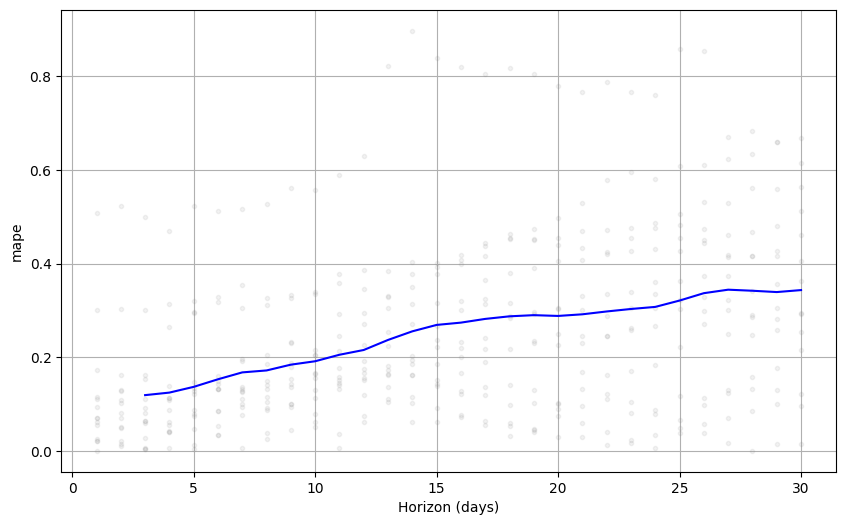

In [ ]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
r2_score(df_cv.y, df_cv.yhat)

0.06465503430782771

In [ ]:
mean_squared_error(df_cv.y, df_cv.yhat)

125172436.44122227

In [ ]:
mean_absolute_error(df_cv.y, df_cv.yhat)

8278.51437134784